# Tutorial Auto-Tagging using different front-end/ different architecture

- date: 2024-10-01
- author: geoffroy.peeters@telecom-paris.fr

The code of the model is based on SincNet
- Paper: https://arxiv.org/pdf/1808.00158
- Code: https://github.com/mravanelli/SincNet/blob/master/dnn_models.py 


## Import packages

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#import torchaudio
from torch.utils.data import Dataset
import torch.optim as optim
import torchsummary

import lightning.pytorch as pl
import torch.optim as optim

import lightning.pytorch as pl
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

import wandb
from pytorch_lightning.loggers import WandbLogger

import json
import yaml
import h5py
import pprint as pp
from tqdm import tqdm
import datetime
from multiprocessing import Pool
import os

import librosa
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
import IPython.display

# -----------------------------
import model_factory 
import importlib
importlib.reload(model_factory) 

from argparse import Namespace
! pip install munch
from munch import munchify

## Parameters

In [26]:
ROOT = '/tsi/data_doctorants/gpeeters/_data/'
base = 'gtzan-genre'
hdf5_audio_file = f'{ROOT}/{base}_audio.hdf5'
pyjama_annot_file = f'{ROOT}/{base}.pyjama'


do_feature = 'waveform'#, 'waveform', 'lms'


param_mel = Namespace()
param_mel.nb_band = 128
param_mel.L_n = 2048
param_mel.STEP_n = 1024

param_patch = Namespace()
param_model = Namespace()
if do_feature == 'waveform':
    param_patch.L_frame = 3200
    param_model.n_in = 1
elif do_feature == 'lms':
    param_patch.L_frame = 64
    param_model.n_in = param_mel.nb_band
param_patch.STEP_frame = int(param_patch.L_frame/2)

param_model.T_in = param_patch.L_frame
param_model.n_out = 10
param_model.batch_size = 128
param_model.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

param_lightning = Namespace()
param_lightning.max_epochs = 500
param_lightning.dirpath='my_model/'
param_lightning.filename='best_model'


## Dataloader

### Test loading pyjama/hdf5

In [4]:
with open(pyjama_annot_file, encoding = "utf-8") as json_fid:
    data_d = json.load(json_fid)
entry_l = data_d['collection']['entry']
audiofile_l = [entry['filepath'][0]['value'] for entry in entry_l]
pp.pprint(audiofile_l[:5])

with h5py.File(hdf5_audio_file, 'r') as hdf5_fid:
    pp.pprint(hdf5_fid[audiofile_l[0]][:].shape)
    pp.pprint(hdf5_fid[audiofile_l[0]].attrs['sr_hz'])
    pp.pprint(hdf5_fid['/'].keys())


['blues+++blues.00000.wav',
 'blues+++blues.00001.wav',
 'blues+++blues.00002.wav',
 'blues+++blues.00003.wav',
 'blues+++blues.00004.wav']
(661794,)
22050
<KeysViewHDF5 ['blues+++blues.00000.wav', 'blues+++blues.00001.wav', 'blues+++blues.00002.wav', 'blues+++blues.00003.wav', 'blues+++blues.00004.wav', 'blues+++blues.00005.wav', 'blues+++blues.00006.wav', 'blues+++blues.00007.wav', 'blues+++blues.00008.wav', 'blues+++blues.00009.wav', 'blues+++blues.00010.wav', 'blues+++blues.00011.wav', 'blues+++blues.00012.wav', 'blues+++blues.00013.wav', 'blues+++blues.00014.wav', 'blues+++blues.00015.wav', 'blues+++blues.00016.wav', 'blues+++blues.00017.wav', 'blues+++blues.00018.wav', 'blues+++blues.00019.wav', 'blues+++blues.00020.wav', 'blues+++blues.00021.wav', 'blues+++blues.00022.wav', 'blues+++blues.00023.wav', 'blues+++blues.00024.wav', 'blues+++blues.00025.wav', 'blues+++blues.00026.wav', 'blues+++blues.00027.wav', 'blues+++blues.00028.wav', 'blues+++blues.00029.wav', 'blues+++blues.0003

### Define features

In [6]:
def f_log(data_m, C = 10000):
    """
    description:
        replacement to log function (to avoid emphasazing very small values)
    """
    return np.log(1 + C*data_m)

def f_get_audio_features(audio_v, sr_hz):
    """
    description:
        compute Log-Mel-Sepctrogram audio features with n_mels=128, window length L_n = 2048, and hop-size STEP_n = 1024
    inputs:
        - audio_v
        - sr_hz
        - data_ext
    outputs:
        - data_m (nb_dim, nb_frame): Log-Mel-Sepctrogram matrix
        - time_sec_v (nb_frame): corresponding time [in sec] of analysis windows
    """
    # --- data (nb_dim, nb_frames)
    mel_data_m = librosa.feature.melspectrogram(y=audio_v, sr=sr_hz, n_mels=param_mel.nb_band, win_length=param_mel.L_n, hop_length=param_mel.STEP_n)
    data_m = f_log(mel_data_m)
    nb_frame = data_m.shape[1]
    time_sec_v = librosa.frames_to_time(frames=np.arange(nb_frame), sr=sr_hz, hop_length=param_mel.STEP_n)

    return data_m, time_sec_v

(128, 647)


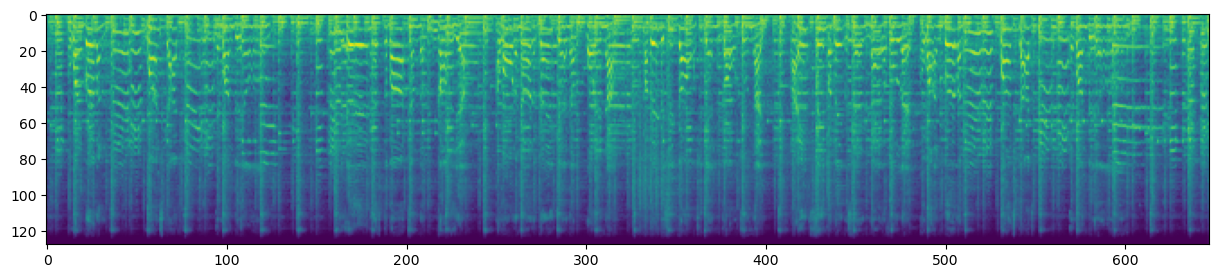

In [7]:
# --- TEST
with h5py.File(hdf5_audio_file, 'r') as hdf5_fid:
    audio_v = hdf5_fid[audiofile_l[0]][:]
    sr_hz = hdf5_fid[audiofile_l[0]].attrs['sr_hz']
data_m, time_sec_v = f_get_audio_features(audio_v, sr_hz)
print(data_m.shape)
plt.imshow(data_m);

In [8]:
def f_get_patches(T, L, S):
    """
    description
    """
    # --- patch_d.L_frame+(nb_patch-1)*patch_d.STEP_frame < nb_frame
    nb_patch = int(np.floor((T - L)/S + 1))
    return [{'start_frame': (num_patch*S), 'end_frame': (num_patch*S)+L} for num_patch in range(nb_patch)]


In [9]:
# --- TEST
f_get_patches(250, param_patch.L_frame, param_patch.STEP_frame)

[{'start_frame': 0, 'end_frame': 64},
 {'start_frame': 32, 'end_frame': 96},
 {'start_frame': 64, 'end_frame': 128},
 {'start_frame': 96, 'end_frame': 160},
 {'start_frame': 128, 'end_frame': 192},
 {'start_frame': 160, 'end_frame': 224}]

### Create Dataset

In [10]:
class GenreDataset(Dataset):
    """
    description
    """

    def __init__(self, hdf5_audio_file, pyjama_annot_file, do_train):

        with open(pyjama_annot_file, encoding = "utf-8") as json_fid: data_d = json.load(json_fid)
        entry_l = data_d['collection']['entry']
        
        self.labelname_dict_l = list(set([entry['genre'][0]['value'] for entry in entry_l]))

        self.do_train = do_train
        if self.do_train:   entry_l = [entry_l[idx] for idx in range(len(entry_l)) if (idx % 5) != 0]
        else:               entry_l = [entry_l[idx] for idx in range(len(entry_l)) if (idx % 5) == 0]

        self.audio_file_l =  [entry['filepath'][0]['value'] for entry in entry_l]

        self.feature_d = {}
        self.patch_l = []
        
        with h5py.File(hdf5_audio_file, 'r') as audio_fid:
            for idx, entry in enumerate(entry_l):
                audio_file= entry['filepath'][0]['value']

                if do_feature == 'waveform':
                    feat_value_m = audio_fid[audio_file][:].reshape(1,-1)
                    
                elif do_feature == 'lms':
                    feat_value_m, _ = f_get_audio_features(audio_fid[audio_file][:], audio_fid[audio_file].attrs['sr_hz'])
                
                idx_label = self.labelname_dict_l.index(entry['genre'][0]['value'])
                self.feature_d[audio_file] = {'X': torch.tensor(feat_value_m).float(), 'y': torch.tensor(idx_label)}
                
                localpatch_l = f_get_patches(feat_value_m.shape[-1], param_patch.L_frame, param_patch.STEP_frame)
                for localpatch in localpatch_l:
                    self.patch_l.append({'audiofile': audio_file,
                                        'start_frame': localpatch['start_frame'],
                                        'end_frame': localpatch['end_frame'],
                                        })

    def __len__(self):
        return len(self.patch_l)

    def __getitem__(self, idx_patch):
        s = self.patch_l[idx_patch]['start_frame']
        e = self.patch_l[idx_patch]['end_frame']
        X = self.feature_d[ self.patch_l[idx_patch]['audiofile'] ]['X'][:,s:e]
        if do_feature == 'lms': X = X.unsqueeze(0) # --- add channel dimension
        y = self.feature_d[ self.patch_l[idx_patch]['audiofile'] ]['y']
        return {'X':X , 'y':y}
    
train_dataset = GenreDataset(hdf5_audio_file, pyjama_annot_file, do_train=True)
valid_dataset = GenreDataset(hdf5_audio_file, pyjama_annot_file, do_train=False)

In [11]:
# --- TEST
print(len(train_dataset))

15200


### Create Dataloader

In [12]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=param_model.batch_size, shuffle=True, num_workers=8, drop_last = True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=param_model.batch_size, shuffle=False, num_workers=8, drop_last = True)

In [14]:
# --- TEST
batch = next(iter(train_dataloader))
print(batch['X'].size())
print(batch['y'].size())

torch.Size([128, 1, 128, 64])
torch.Size([128])


## Model

In [15]:
with open('config_autotagging.yaml', 'r') as fid: 
    cfg_dic = yaml.safe_load(fid)
config = munchify(cfg_dic)


class AutoTaggingModel(nn.Module):
    def __init__(self, config, current_input_dim):
        super(AutoTaggingModel, self).__init__()
        self.block_l = []
        for config_block in config.model.block_l:
            sequential_l = []
            for config_sequential in config_block.sequential_l:
                component_l = []
                for config_component in config_sequential.component_l:
                    module, current_input_dim = model_factory.f_parse_component(config_component[0], config_component[1], current_input_dim) 
                    component_l.append( module )
                sequential_l.append( nn.Sequential (*component_l) )
            self.block_l.append( nn.ModuleList(sequential_l) )
            self.model = nn.ModuleList(self.block_l)

    def forward(self, X, do_verbose=False):
        for idx_block, block in enumerate(self.model):
            for idx_sequential, sequential in enumerate(block):
                if do_verbose: print(f'{idx_block}/{idx_sequential}---------------------------------\n{sequential}\n> in: {X.size()}')
                X = sequential( X )
                if do_verbose: print(f'> out: {X.size()}')
        return X


if do_feature == 'waveform':
    m, C, T = 64, 1, 3200
    model = AutoTaggingModel(config, [m, C, T])
if do_feature == 'lms':
    m, C, H, W = 64, 1, 128, 64
    model = AutoTaggingModel(config, [m, C, H, W])

model = model.to(param_model.device)

In [16]:
# --- TEST
if do_feature == 'waveform':
    m, C, T = 64, 1, 3200

    #X = torch.randn(m, C, T).to(param_model.device)
    #print(model(X, True).size())
    
    torchsummary.summary(model, input_size=(C, T))

if do_feature == 'lms':
    m, C, H, W = 64, 1, 128, 64

    #X = torch.randn(m, C, H, W).to(param_model.device)
    #print(model(X, True).size())

    torchsummary.summary(model, input_size=(C, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         LayerNorm-1           [-1, 1, 128, 64]          16,384
            Conv2d-2            [-1, 80, 1, 60]          51,280
         nnSqueeze-3               [-1, 80, 60]               0
         LayerNorm-4               [-1, 80, 60]           9,600
         LeakyReLU-5               [-1, 80, 60]               0
           Dropout-6               [-1, 80, 60]               0
            Conv1d-7               [-1, 60, 56]          24,060
         MaxPool1d-8               [-1, 60, 18]               0
         LayerNorm-9               [-1, 60, 18]           2,160
        LeakyReLU-10               [-1, 60, 18]               0
          Dropout-11               [-1, 60, 18]               0
           Conv1d-12               [-1, 60, 14]          18,060
        MaxPool1d-13                [-1, 60, 4]               0
        LayerNorm-14                [-1

### Test model

In [18]:
batch = next(iter(train_dataloader))
model(batch['X'].to(param_model.device)).size()

torch.Size([128, 10])

## Training using TorchLightning

### W&B configuration

### TorchLightning

In [19]:
def get_accuracy(hat_y, y):
    """ Manually compute accuracy """
    preds = torch.argmax(hat_y, dim=1)  # Get the predicted class (index of max logit)
    correct = (preds == y).float()  # Compare with ground truth and cast to float
    accuracy = correct.sum() / len(correct)  # Compute mean accuracy over the batch
    return accuracy

class AutoTaggingLigthing(pl.LightningModule):
    def __init__(self, in_model):
        super().__init__()
        self.model = in_model
        self.loss = nn.CrossEntropyLoss()

    def training_step(self, batch, batch_idx):
        hat_y = self.model(batch['X'])
        loss = self.loss(hat_y, batch['y'])

        accuracy = get_accuracy(hat_y, batch['y'])
        self.log("train_loss", loss, prog_bar=True)
        self.log('train_acc', accuracy, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        hat_y = self.model(batch['X'])
        loss = self.loss(hat_y, batch['y'])
        
        accuracy = get_accuracy(hat_y, batch['y'])
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), 0.001)
        return optimizer

### Training

In [20]:
my_lighting = AutoTaggingLigthing( model )
early_stop_callback = EarlyStopping(monitor="val_loss", patience=10, verbose=True, mode="min")
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath=param_lightning.dirpath, filename=param_lightning.filename, save_top_k=1, mode='min')
trainer = pl.Trainer(accelerator="gpu",  max_epochs = param_lightning.max_epochs, callbacks = [early_stop_callback, checkpoint_callback])
trainer.fit(model=my_lighting, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/gpeeters/anaconda3/envs/conda_gpeeters_202 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please

Epoch 0: 100%|██████████| 118/118 [00:03<00:00, 33.96it/s, v_num=0, train_loss=0.807, train_acc=0.688, val_loss=1.550, val_acc=0.521]

Metric val_loss improved. New best score: 1.553


Epoch 1: 100%|██████████| 118/118 [00:04<00:00, 28.27it/s, v_num=0, train_loss=0.756, train_acc=0.703, val_loss=1.340, val_acc=0.586]

Metric val_loss improved by 0.208 >= min_delta = 0.0. New best score: 1.344


Epoch 2: 100%|██████████| 118/118 [00:03<00:00, 29.80it/s, v_num=0, train_loss=0.328, train_acc=0.875, val_loss=1.130, val_acc=0.654]

Metric val_loss improved by 0.217 >= min_delta = 0.0. New best score: 1.127


Epoch 12: 100%|██████████| 118/118 [00:03<00:00, 29.75it/s, v_num=0, train_loss=0.110, train_acc=0.961, val_loss=1.590, val_acc=0.666] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 1.127. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 118/118 [00:03<00:00, 29.72it/s, v_num=0, train_loss=0.110, train_acc=0.961, val_loss=1.590, val_acc=0.666]


## Evaluation

In [21]:
best_model_path = checkpoint_callback.best_model_path
#best_model_path = 'my_model/best_model.ckpt'
print(f"Best model saved at: {best_model_path}")
my_lighting = AutoTaggingLigthing.load_from_checkpoint(best_model_path, in_model=model)

print( type(model) )
print( type(my_lighting) )
print( type(my_lighting.model) )

model = my_lighting.model
model.to(device)

Best model saved at: /home/ids/gpeeters/proj_tuto-ISMIR2024/code/my_model/best_model.ckpt
<class '__main__.AutoTaggingModel'>
<class '__main__.AutoTaggingLigthing'>
<class '__main__.AutoTaggingModel'>


NameError: name 'device' is not defined

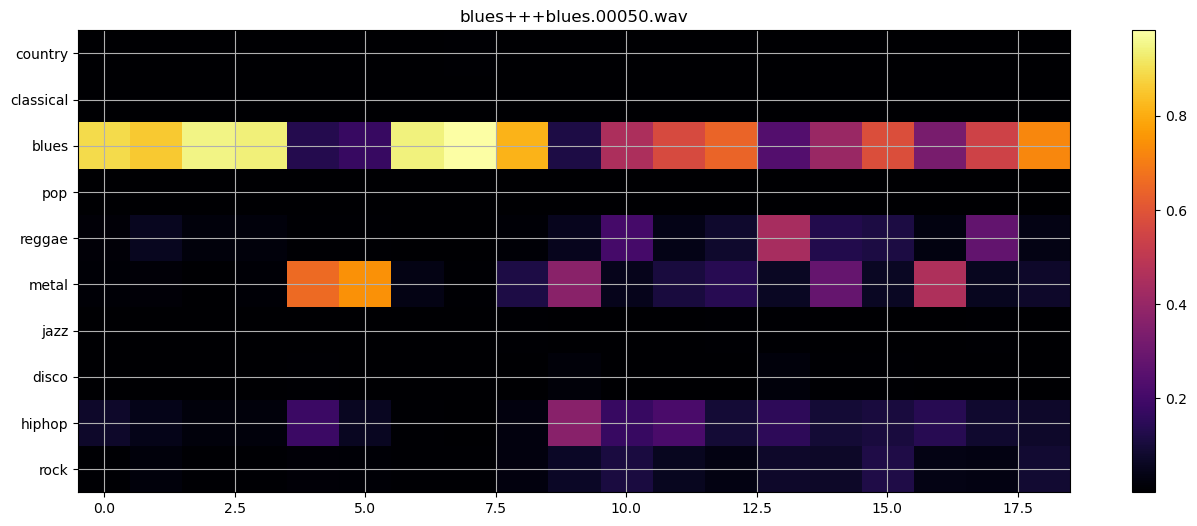

In [24]:
def F_tag_o_gram(audio_v, sr_hz):
    """
    """
    # --- Compute the audio features
    if do_feature == 'waveform':    feat_value_m = audio_v.reshape(1,-1)
    elif do_feature == 'lms':       feat_value_m, _ = f_get_audio_features(audio_v, sr_hz)
                
    # --- Split matrix into patches
    nb_frame = feat_value_m.shape[1]
    patch_info_l = f_get_patches(feat_value_m.shape[-1], param_patch.L_frame, param_patch.STEP_frame)
    nb_patch = len(patch_info_l)
    data_3m = np.zeros((nb_patch, feat_value_m.shape[0], param_patch.L_frame))
    for idx in range(nb_patch):
        data_3m[idx, :, :] = feat_value_m[:, patch_info_l[idx]['start_frame']:patch_info_l[idx]['end_frame']]

    # --- Convert numpy to torch tensor
    X = torch.from_numpy(data_3m).float().to(param_model.device)
    if do_feature == 'lms': X = X.unsqueeze(1) # --- add channel dimension

    # --- Get prediction from model
    model.eval()
    y_hat = model(X)
    predicted = F.softmax(y_hat, dim=1)
    # --- Convert from torch tensor to numpy
    y_hat_m = predicted.cpu().detach().numpy()

    fig, axes = plt.subplots(1, 1, figsize=(16, 6))
    im = axes.imshow(y_hat_m.T, aspect='auto', interpolation=None, cmap=plt.get_cmap('inferno'))
    axes.set_yticks(np.arange(0,len(valid_dataset.labelname_dict_l)))
    axes.set_yticklabels(valid_dataset.labelname_dict_l)
    axes.grid(True)
    fig.colorbar(im, orientation='vertical')

    return


# ---------------------------------------------
# ---------------------------------------------
# ---------------------------------------------
audio_file= valid_dataset.audio_file_l[10]

with h5py.File(hdf5_audio_file, 'r') as audio_fid:
    audio_value_v = audio_fid[audio_file][:]
    audio_sr_hz = audio_fid[audio_file].attrs['sr_hz']
F_tag_o_gram(audio_value_v, audio_sr_hz)
plt.title(audio_file)
IPython.display.Audio(data=audio_value_v, rate=audio_sr_hz)

### Display learned filters Conv1D

In [352]:
#weight = model.frontend[1].weight # --- conv1D
#weight = model.frontend[1].filters # --- SincNet
named_modules_dict = dict(model.named_modules())
#weight = named_modules_dict['model.0'][1].weight
weight = named_modules_dict['model.0'][1].filters

AttributeError: 'SincConv_fast' object has no attribute 'weight'

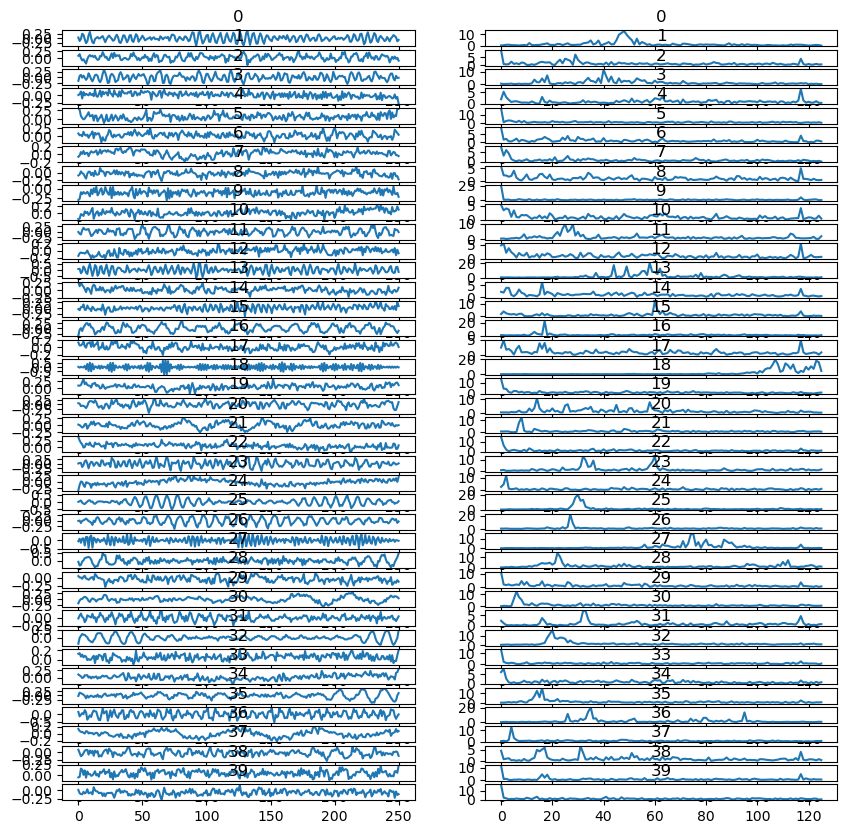

In [342]:
plt.figure(figsize=(10,10))
nb_filter = weight.size()[0]
nb_filter = 40
for num_filter in range(nb_filter):
    value = weight[num_filter,:,:].squeeze().detach().cpu() # --- conv1D
    plt.subplot(nb_filter, 2, 2*num_filter+1)
    plt.plot( value ); plt.title(num_filter)
    plt.subplot(nb_filter, 2, 2*num_filter+2)
    plt.plot(np.abs(np.fft.rfft(value)) ); plt.title(num_filter)

### Display learned filters SincNet

torch.Size([80, 1, 251])